# Projeto final de Aprendizado de Máquina: análise e predição de dados clínicos
## UFMG - 2023/1 - Professor Adriano Veloso
### Luís Felipe Ramos Ferreira - 2019022553

Link para apresentação no youtube: link

# Introdução

O projeto final implementado e apresentado neste *notebook* apresenta a aplicação de conceitos e algoritmos de Aprendizado de Máquina em um contexto da área da saúde. Mais especificamente, os dados utilizados foram fornecidos por uma equipe ligada ao Hospital das Clínicas de Belo Horizonte e representam condições e características relacionadas a pacientes internados nos hospitais, como apresentação de comorbidades, resultados de exames fisiológicos, complicações durante internação, etc.

O objetivo principal com a utilização destes dados é prever, a partir destas informações, o período de tempo que o paciente irá ficar internado na UTI (Unidade de Tratamento Intensivo), de modo que os custos e equipamentos possam ser redirecionados da maneira correta e, dessa maneira, o maior número de vidas possam ser salvas.

Nesse cenário, duas abordagens podem ser levados em consideração. Como o tempo de internação na UTI esta presente nos dados como uma variável numérica, pode-se lidar coma  situação como um problema de regressão. No entanto, para aumentar o paradigma de estuda, podemos discretizar os dados relativos ao tempo de internação, em categorias que separam os pacientes entre aqueles ue ficaram mais ou menos que 3 dias internados, por exemplo. Assim, vários algoritmos e abordagens diferentes podem ser analisados.

Em resumo, o problema consiste em, possuindo dados relativos à admissão de um apciente no hospital, como dados de comorbidades, idade, dados fisiológicos de exames, etc, seja possível fazer uma previsão adequada do tempo que o paciente ficará internado na UTI. Naturalmente, este é um problema difícil, mas com grande importância em uma escala global.

# Metodologia

Um vasto conjunto de algoritmos e técnicas foi utilizado de forma supervisionada, desde modelos tradicionais e introdutórios até redes neurais mais complexas, para que um _benchmark_ entre todas as abordagens pudesse ser feito. Em particular, foram testadas abordagens como:

- _SVM (Support Vector Machine)_
- _Naive Bayes_
- _Random Forest_ (Regressão e classificação)
- _Gradient Boosting_ (Regressão e classificação)
- _XGBoost_ (Regressão e classificação)

Além disso, a técnica de [_grid search_](https://scikit-learn.org/stable/modules/grid_search.html) foi utilizada juntamente a uma abordagem de _cross validation_ com o intuito de encontrar os melhores hiperparâmetros para os modelos que permitem alcançar um resultado ótimo, para cada tipo de modelagem.

# Bibliotecas utilizadas no desenvolvimento

In [63]:
import os
import json
import time
import random
import pickle

import numpy as np
import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import xgboost as xgb

start = time.time()

# Constantes

Aqui estão as definições de algumas constantes que são utilizadas no decorres do código. Em particular, as constantes _MAXIMUM_UNIT_LENGTH_STAY_ e _NUMBER_OF_BINS_ dizem respeito à forma como os dados de tempo de permanência serão discretizados.

In [64]:
# system
RANDOM_STATE: np.int8 = 42
TEST_SIZE: np.float64 = 0.3
SAVE_FINAL_DATA_CSV: bool = False
FINAL_DATA_PATH: np.str_ = "data/processed/final_data.csv"

# data
MAXIMUM_UNIT_LENGTH_STAY: np.int32 = 250
BINS: list[int] = [0, 1, MAXIMUM_UNIT_LENGTH_STAY]

# tuning
CROSS_VALIDATION_FOLDS: np.int8 = 5

# Engenharia de dados

Aqui é feita a engenharia de dados de todos os arquivos __csv__ que são utilizados no projeto, de modo que ao final, três _dataframes_ são criados. Um deles, denominado _final_data_, contêm todas as _features_ utilziadas durante a construção dos modelos. Os _dataframes_ denominados _labels_regression_ e _labels_classification_ contêm respectivamente, as _labels_ utilizadas durante o treino e teste de cada um dos tipos de modelo de aprendizado de máquina utilizados.

Em particular, quatro conjuntos separados de dados são utilizados para garantir que o modelo tenha todas as informações necessárias durante seu treinamento, sendo que cada um deles contêm:

- Comorbidades e Capacidades Funcionais
- Razões para internação na UTI
- Complicações no primeira dia de internação na UTI
- Dados fisiológicos e laboratorias na primeira hora de internação

In [77]:
if not os.path.exists(FINAL_DATA_PATH):
    df: pd.DataFrame = pd.read_csv("data/raw/folha3.csv")
    ages: pd.Series = df["Age"].copy()
    df: pd.DataFrame = df[
        df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)
    ].copy()
    df.dropna(axis=1, thresh=5000, inplace=True)
    df.fillna(value=0, inplace=True)
    labels: pd.DataFrame = df["UnitLengthStay"].copy()
    df = df.iloc[:, 22:]
    sheet_3_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

    # getting data from motivos de internação na UTI
    df = pd.read_csv("data/raw/folha4.csv")
    df: pd.DataFrame = df[
        df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)
    ].copy()
    df = df.iloc[:, 21:]
    df.dropna(axis=1, thresh=5000, inplace=True)
    df.fillna(value=0, inplace=True)
    sheet_4_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

    # getting data from complicações no primeiro dia na uti
    df = pd.read_csv("data/raw/folha5.csv")
    df: pd.DataFrame = df[
        df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)
    ].copy()
    df = df.iloc[:, 21:]
    df.dropna(axis=1, thresh=5000, inplace=True)
    df.fillna(value=0, inplace=True)
    sheet_5_df: pd.DataFrame = (df == "Verdadeiro").astype(int)

    # getting data from dados fisiologicos na UTI
    df = pd.read_csv("data/raw/folha6.csv")
    df: pd.DataFrame = df[
        df["UnitLengthStay"].apply(lambda x: x <= MAXIMUM_UNIT_LENGTH_STAY)
    ].copy()
    df = df.iloc[:, 21:]
    df.dropna(axis=1, thresh=5000, inplace=True)
    df.fillna(value=0, inplace=True)
    sheet_6_df: pd.DataFrame = df.copy()


    labels_regression: pd.DataFrame = labels.copy()
    labels_classification: pd.DataFrame = pd.cut(
        x=labels_regression, bins=BINS, labels=np.arange(len(BINS) - 1)
    )
    labels_classification.name = "isMoreThanOneDayInUnit"

    # joining dataframes into final data
    final_data: pd.DataFrame = pd.concat(
        [
            ages,
            sheet_3_df,
            sheet_4_df,
            sheet_5_df,
            sheet_6_df,
            labels_regression,
            labels_classification
        ],
        axis=1,
        join="inner",
    )

    if SAVE_FINAL_DATA_CSV:
        final_data.to_csv("data/processed/final_data.csv")

else:
    final_data: pd.DataFrame = pd.read_csv(FINAL_DATA_PATH)
    labels_regression: pd.Series = final_data["UnitLengthStay"].copy()
    labels_classification: pd.Series = final_data["isMoreThanOneDayInUnit"].copy()


features: pd.DataFrame = final_data.iloc[:, :-2].copy()

NameError: name 'FINAL_DATA_PATH' is not defined

# Utilitários

Aqui são definidas alguams funções utilitárias para o desenvolvimento do projeto de forma geral.

In [66]:
"""Compute machine learning models metrics given the predictions and the true values

Parameters
----------
y_true : npt.NDArray[np.float64]
    The true values
y_pred : npt.NDArray[np.float64]
    The predictions
type: np.str_
    The type of model used to make the predictions (default is 'classification')
dump: bool, optional
    A flag used to dump or not the JSON created with the metrics (default is False)
dump_filename: np.str_, optional
    The name of the file that is goind to be dumped (default is 'dumpfile')
plot_confusion_matrix: bool, optional
    A flag used to plot or not the confusion matrix created by the predictions of  a classififer model (default is False)

Returns
-------
dict
    A dictionary with the metrics run information
"""


def get_run_info(
    y_true: npt.NDArray[np.float64],
    y_pred: npt.NDArray[np.float64],
    type: np.str_ = "classification",
    dump: np.bool_ = False,
    dump_filename: np.str_ = "dumpfile",
    plot_confusion_matrix: bool = False,
) -> dict:
    if type == "classification":
        accuracy_score: np.float64 = metrics.accuracy_score(
            y_true=y_true, y_pred=y_pred
        )
        precision_score: np.float64 = metrics.precision_score(
            y_true=y_true, y_pred=y_pred
        )
        recall_score: np.float64 = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        f1_score: np.float64 = metrics.f1_score(y_true=y_true, y_pred=y_pred)
        confusion_matrix: npt.NDArray[np.int32] = metrics.confusion_matrix(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "accuracy_score": accuracy_score,
            "precision_score": precision_score,
            "recall_score": recall_score,
            "f1_score": f1_score,
            "confusion_matrix": confusion_matrix,
        }

        if plot_confusion_matrix:
            metrics.ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix,
                display_labels=["Um dia na UTI", "Mais que um dia na UTI"],
            ).plot()

    else:  # regression
        mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred
        )
        root_mean_squared_error: np.float64 = metrics.mean_squared_error(
            y_true=y_true, y_pred=y_pred, squared=False
        )
        mean_absolute_error: np.float64 = metrics.mean_absolute_error(
            y_true=y_true, y_pred=y_pred
        )

        run_info: dict = {
            "mean_squared_error": mean_squared_error,
            "root_mean_squared_error": root_mean_squared_error,
            "mean_absolute_error": mean_absolute_error,
        }

    if dump:
        dump_filename: np.str_ = dump_filename or f"{type}_run_info{time.time()}"
        with open(dump_filename) as file:
            json.dump(run_info, file, indent=4)

    return run_info


"""Apply grid search on the estimator passed with the desired grid values

Parameters
----------
estimator: estimator
    The estimator to apply grid search on
grid: dict
    The grid with the different values to apply the search
data: list
    List with X_train, y_train, X_test and y_test data
type: np.str_
    The type of model used to make the predictions (default is 'classification')
get_best_run_info: bool, optional
    A flag used to get or not the best parameters run information (default is True)

Returns
-------
dict
    A dictionary with the metrics run information
"""


def apply_grid_search(
    estimator,
    grid: dict,
    data: list,
    type: np.str_ = "classification",
    return_best_run_info: bool = True,
) -> dict:
    if type == "classification":
        scorer = metrics.make_scorer(metrics.fbeta_score, beta=1.2)
    else:
        scorer = metrics.make_scorer(
            metrics.mean_squared_error, squared=False, greater_is_better=False
        )
    X_train, X_test, y_train, y_test = data
    grid_cv_classifier = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        cv=CROSS_VALIDATION_FOLDS,
        n_jobs=-1,
        scoring=scorer,
        refit=True,
    )
    grid_cv_classifier.fit(X_train, y_train)
    y_pred: npt.NDArray[np.float64] = grid_cv_classifier.predict(X_test)
    estimator_name: np.str_ = estimator.__class__.__name__
    with open(f"models/{estimator_name}", "wb") as file:
        pickle.dump(grid_cv_classifier, file)
    if return_best_run_info:
        display(grid_cv_classifier.best_params_)
        return get_run_info(
            y_true=y_test,
            y_pred=y_pred,
            type=type,
            plot_confusion_matrix=True,
            dump=True,
            dump_filename=f"results/{estimator_name}",
        )


"""Reset random number geneators seeds

Parameters
----------

Returns
-------

"""


def reset_seeds() -> None:
    SEED: np.int8 = 42
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

# Ambiente de desenvolvimento

Os códigos disponiblizados abaixo foram desenvolvidos no meu computador local em um ambiente _Anaconda_, cujas configurações estão disponibilizadas no arquivos _environment.yml_, juntamente das versões dos pacotes utilizados. A versão da linguagem _Python_ utilizada foi a 3.11.3.

Para rodar o programa, basta rodar as células iterativamente e acompanhar os resultados que serão mostrados em tela. Os modelos foram todos salvos e armazenados de modo que não fosse necessário fazer todo o _grid search_ a cada utilização do _notebook_.

# Análise exploratória do conjunto de dados utilizado

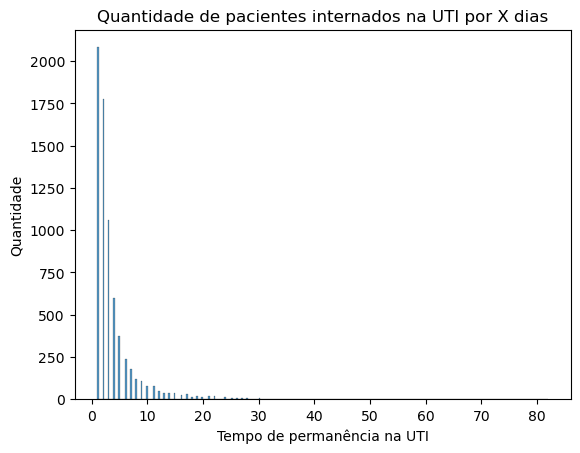

In [67]:
plt.title("Quantidade de pacientes internados na UTI por X dias")
ax = sns.histplot(data=labels_regression)
ax.set_ylabel("Quantidade")
ax.set_xlabel("Tempo de permanência na UTI")
None

No caso discretizado, as classes são definidas de acordo com os parâmetros iniciais escolhidos no início da implementação. Em particular, por consião, optou-se por separar os pacientes em duas classes discretas de tempo de permanência na UTI. As classes são:

- 0: Pacientes que ficaram um dia na UTI
- 1: Pacientes que ficaram mais do que um dia na UTI

Essa escolha foi feita com base no fato de que a base de dados é extremamente desbalanceada, e grande parte dos pacientes presentes nela ficaram apenas 1 dia na UTI, como podemos ver no gráfico acima.

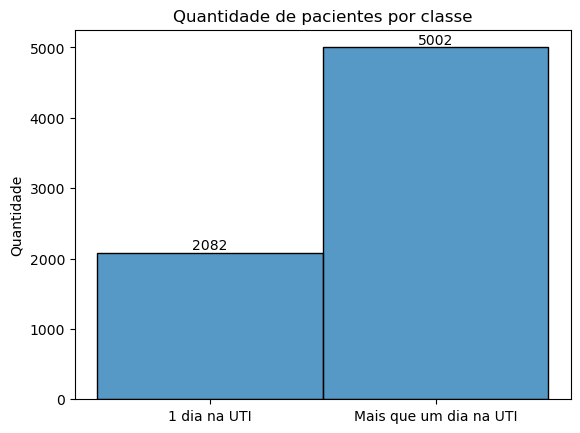

In [68]:
plt.title("Quantidade de pacientes por classe")
ax = sns.histplot(data=labels_classification)
for rect in ax.patches:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
    )
ax.set_xlabel(None)
ax.set_ylabel("Quantidade")
ax.set_xticks(ticks=np.arange(len(BINS) - 1))
ax.set_xticklabels(["1 dia na UTI", "Mais que um dia na UTI"])
None

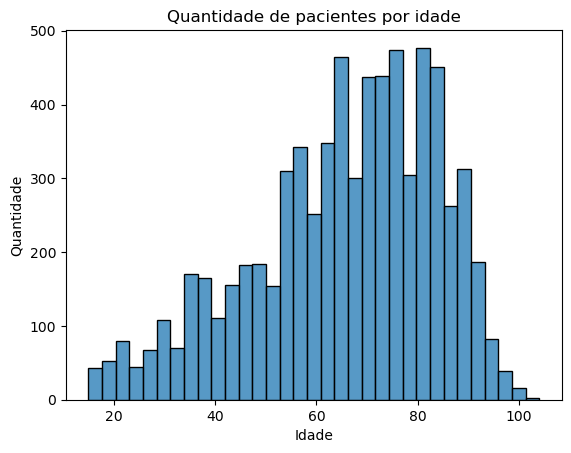

In [69]:
plt.title("Quantidade de pacientes por idade")
ax = sns.histplot(data=final_data["Age"])
ax.set_xlabel("Idade")
ax.set_ylabel("Quantidade")
None

A distribuição de idade dos pacientes parece claramente seguir uma distribuição normal centrada por volta de 75 anos de idade. Como sabe-se, pessoas mais velhas possuem mais comorbidades e possuem maior chance de precisarem de um tratamento longo em uma unidade de tratamento intensivo.

# Regressão

Modelos de regressão são modelos estatísticos que tentam prever e estimar um valor numérico contínuo para um determinado alvo, a partir dos dados disponibilizados. São modelos extremamente importantes e que ajudam a compreender como um conjunto de variáveis independentes afeta o resultado de uma outra variável.

Neste cenário, a partir dos dados disponibilizados, modelo de regressão serão avaliados para a tentativa de prever o tempo de permanência de pacientes na UTI, em dias. As métricas que serão utilizadas para avaliar os  modelos serão o erro absoluto médio, o erro quadrado médio e a raiz do erro quadrado médio.

In [70]:
data_regression = train_test_split(
    features, labels_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## _Random Forest Regressor_

Um modelo de floresta aleatória é um tipo de modelo de _ensemble_ estatístico que combina inúmeras árvores de decisão para fazer o cálculo final desejado. No caso de um modelo de regressão, é calculada a média dos valores previstos por cada árvore para a obtenção do valor final.

Esse tipo de modelo faz uso de aleatoriedade para garantir uma boa generalização do modelo e evitar _overfitting_, de modo a construir um bom resultado. Além disso, regressores de floresta aleatória são bons em lidar com relações não lineares entre dados e fornecem ao final do treinamento um conjunto de importâncias das _features_ utilizadas durante o treinamento.

In [71]:
rfr_grid: dict = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [20, 30, 40, 50, 60, None],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "random_state": [RANDOM_STATE],
}
apply_grid_search(
    estimator=RandomForestRegressor(),
    grid=rfr_grid,
    type="regression",
    data=data_regression,
)

KeyboardInterrupt: 

## _Gradient Boosting Regressor_

Um modelo de _Gradient Boosting_ é também um modelo de _ensemble_ estatístico, similar à outros modelos de _boosting_, de modo que utiliza a combinação de diversos outros modelos fracos (principalmente árvores de decisão) para chegar a um resultado eficiente. Em particular, o algoritmo de _Gradient Boosting_ faz o uso de descidas de gradiente para minimizar sua função de perda durante o treinamento, e daí vêm o seu nome.

In [ ]:
gbr_grid: dict = {
    "loss": ["squared_error", "absolute_error", "huber", "quantile"],
    "learning_rate": [0.05, 0.1, 0.5, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 10, 30, None],
    "random_state": [RANDOM_STATE],
    "max_features": ["sqrt", "log2", None],
}
apply_grid_search(
    estimator=GradientBoostingRegressor(),
    grid=gbr_grid,
    type="regression",
    data=data_regression,
)

{'mean_squared_error': 25.65485210024887,
 'root_mean_squared_error': 5.065061904878249,
 'mean_absolute_error': 2.6850923645108455}

## _XGBoost Regressor_

Tal qual os outros algoritmos citados, o _XGBoost_ também é uma abordagem de modelo de aprnedizado de máquina que faz uso de _bosting_ para alcançar um resultado favorável. Ele é um tipo de _gradient boosting_, ou seja, faz uso de descidas de gradiente para minimizar sua função de perda. Sua implementação, no entanto, é um pouco mais extrema e complexa do que a de um _gradient boosting_ padrão, como visto anteriormente, e daí também vẽm sue nome. 

In [ ]:
xgbr_grid: dict = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_leaves": [0, 5, 10, 20],
    "max_depth": [20, 30, 40, 50, 60],
    "random_state": [RANDOM_STATE],
}
apply_grid_search(
    estimator=xgb.XGBRegressor(),
    grid=xgbr_grid,
    type="regression",
    data=data_regression,
)

{'mean_squared_error': 29.089426696300848,
 'root_mean_squared_error': 5.393461476297095,
 'mean_absolute_error': 2.839833737584926}

importqncia blablabla

# Classificação

Como reiterado anteriormente, diversos algoritmos de classificação também serão utilizados para analisar a performance dentro da base de dados apresentada, após sua discretização conforme a definição escolhida. Diversos modelos clássicos serão testados e, posteriormente, alguns modelos mais complexos e atuais de _boosting_ também serão analisados.

Modelos de classificação são, de forma, modelo estatísticos de aprendizado de máquina que possuem como objetivo encontrar uma funlção capaz de, dados inúmeros dados/variáveis independentes representantes de uma instância, prever à qual classe de objetos essa instãncia pertence. Modelos de classificação possuem uma quantidade exorbitante de aplicações nos mais diversos campos, como na classificação de doenças, mensagens de _spam_, imagens, etc.

Considerando o problema proposto, é evidente que, julgando um mundo ideal e utópico, o desejado é possuir recursos o suficiente para se alocar recursos à todos os pacientes que os necessitam e irão ficar mais que um dia na UTI. Nesse cenário utópico, bastaria assumir que todos os apcientes que chegam irão potencialmente ficar na UTI mais que um dia e tudo estaria certo. No entanto, a realidade é bem distante dessa, e a alocação de recursos deve ser feita com muita cautela para evitar gastos excessivos que prejudicariam o hospital, assim como garantir a saúde dos pacientes. Assim, para garantir um modelo ótimo, os hiperparâmetros serão otimizados considerando a métrica de _f $\beta$-score_, com $\beta$ igual a 1.2. Assim, iremos dar um peso a mais para que o modelo capture todos aqueles pacientes que irão necessitar de muitos recursos, embora ainda consideremos de grande importância que pacientes que necessitem de poucos recursos e vão ficar apenas um dia na UTI não sejam classificados incorretamente.


## Separação do dados

In [ ]:
data_classification = train_test_split(
    features, labels_classification, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## _Support Vector Machine_ (SVM)

O _SVM_ é um modelo de aprendizado de máquina que, em suma, tem como objetivo encontrar o melhor _Perceptron_ dentre aqueles possíveis para a base de dados. Ele, no entanto, funciona bem para classificação de dados não linearmente separáveis, já que com ele é possível utilizar do parâmetro de _kernel_, que aumenta o poder de generalização do modelo linear. É um algoritmo muito útil e que também permite o uso de regulizadores para evitar _overfitting_.

{'degree': 3, 'kernel': 'poly'}

{'accuracy_score': 0.6947318908748824,
 'precision_score': 0.6947318908748824,
 'recall_score': 1.0,
 'f1_score': 0.8198723286150431,
 'confusion_matrix': array([[   0,  649],
        [   0, 1477]])}

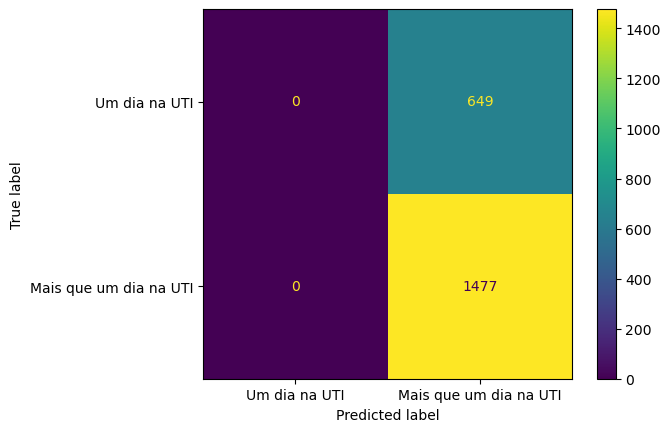

In [ ]:
svm_grid: dict = {"kernel": ["linear", "sigmoid", "poly", "rbf"], "degree": [3, 4]}
apply_grid_search(estimator=SVC(), grid=svm_grid, data=data_classification)

## _Naive Bayes_

O algoritmo de _Naive Bayes_ é um tipo de algoritmo probabilístico que se baseia inteiramente na estatística bayesiana de probabilidades condicionais. É um modelo simples e por isso já se espera que os resultados obtidos com ele não sejam tão bons.

{}

{'accuracy_score': 0.4891815616180621,
 'precision_score': 0.8040435458786936,
 'recall_score': 0.35003385240352064,
 'f1_score': 0.4877358490566038,
 'confusion_matrix': array([[523, 126],
        [960, 517]])}

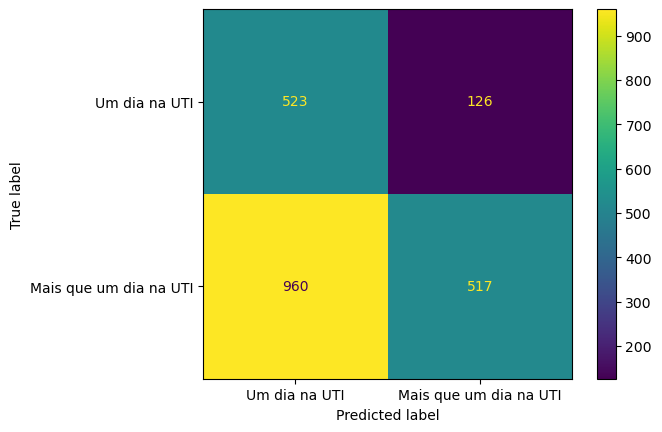

In [ ]:
nb_grid: dict = {}
apply_grid_search(estimator=GaussianNB(), grid=nb_grid, data=data_classification)

## _Decision Tree_

O algoritmo de árvore de decisão também é um algoritmo de aprendizado supervisionado simples, que constrói um modelo de árvore em que a cada nó se faz uma "decisão" que irá dividir o conjunto de dados em subconjuntos menores de acordo com as características mais importante no momento das separações.

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'random_state': 42}

{'accuracy_score': 0.5973659454374413,
 'precision_score': 0.7203690560681334,
 'recall_score': 0.6872037914691943,
 'f1_score': 0.7033957033957033,
 'confusion_matrix': array([[ 255,  394],
        [ 462, 1015]])}

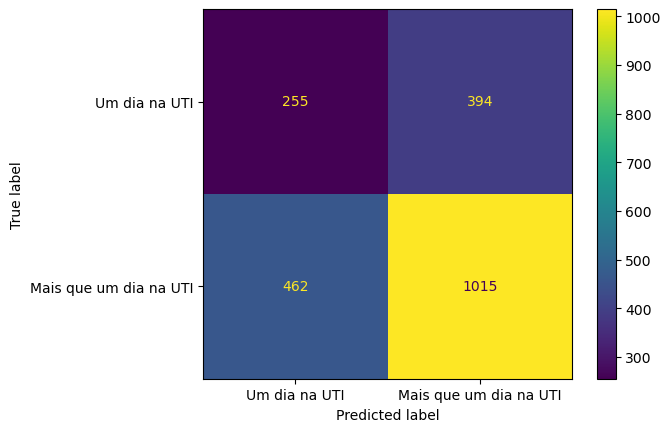

In [ ]:
dt_grid: dict = {
    "random_state": [RANDOM_STATE],
    "max_depth": [10, 20, 30, 40, 50, 60, None],
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": ["balanced"],
}
apply_grid_search(
    estimator=DecisionTreeClassifier(), grid=dt_grid, data=data_classification
)

## _Gradient Boosting Classifier_

Um modelo de _Gradient Boosting_, como já citado no caso anterior de regressão, é um modelo de _ensemble_ estatístico, similar à outros modelos de _boosting_, de modo que utiliza a combinação de diversos outros modelos fracos (principalmente árvores de decisão) para chegar a um resultado eficiente. Em particular, o algoritmo de _Gradient Boosting_ faz o uso de descidas de gradiente para minimizar sua função de perda durante o treinamento, e daí vêm o seu nome. 

Para o caso de aprendizado supervisionado, o algoritmo irá tentar utilizar um modelo de votos entre cada modelo fraco criado para encontrar o resultado fnal de uma instância cuja qual deseja-se saber a classe.

In [ ]:
gbc_grid: dict = {
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.05, 0.1, 0.5, 1],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 10, 30, None],
    "random_state": [RANDOM_STATE],
    "max_features": ["sqrt", "log2", None],
}
apply_grid_search(
    estimator=GradientBoostingClassifier(), grid=gbc_grid, data=data_classification
)

KeyboardInterrupt: 

## _Random Forest Classifier_

Da mesma forma, assim como explicado no caso de regressão, um algoritmo de floresta aleatória faz o uso de diversos modelos fracos e os combina para alcançar um resultado otimizado na hora da classificação.

In [ ]:
rfc_grid: dict = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [20, 30, 40, 50, 60, None],
    "criterion": ["gini", "entropy"],
    "random_state": [RANDOM_STATE],
}
apply_grid_search(
    estimator=RandomForestClassifier(), grid=rfc_grid, data=data_classification
)

KeyboardInterrupt: 

## _XGBoost_

Por fim, também como já citado, o algoritmo de _XGBoost_ também faz uso de um modelo de _boosting_ para classificar as instâncias, embora seja um caso particular e extremo do _Gradient Boosting_.

{'accuracy_score': 0.8154550076258261,
 'precision_score': 0.8351893095768375,
 'recall_score': 0.7772020725388601,
 'f1_score': 0.8051529790660226,
 'confusion_matrix': array([[854, 148],
        [215, 750]])}

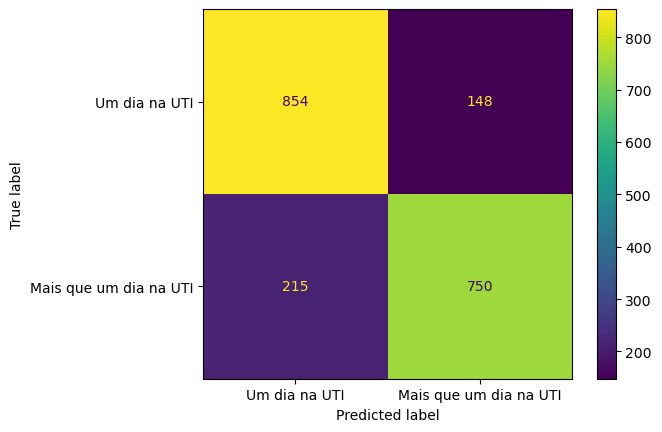

In [ ]:
xgbc_grid: dict = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_leaves": [0, 5, 10, 20],
    "max_depth": [20, 30, 40, 50, 60],
    "random_state": [RANDOM_STATE],
}
apply_grid_search(
    estimator=xgb.XGBClassifier(), grid=xgbc_grid, data=data_classification
)

## Conclusão

O projeto final da disciplina permitiu que diversos modelos diferentes pudessem ser avaliados no processo de previsão de uma variável aleatória desejada. Em particular, dada a natureza dos dados disponibilizados, foi possível experimentar tantos modelos de regressão como modelos de classificação, o que garantiu que os conteúdos vistos em sala pudessem ser ainda melhor absorvidos e expandidos.

Outro fator interessante é  o uso do _grid search_ para otimização dos hiperparâmetros. O projeto forneceu um ambiente favorável para aumentar e praticar o conhecimento relativo à esse tipo de técnica, assim como também de fatores relacionados à _cross validation_, métricas e funções de perda, etc.

Em relação ao resultado obtido, infere-se que com uma base de dados maior um modelo mais efetivo pode ser criado. 7000 instâncias é um valor de certa forma limitante para garantia de de criação de um modelo classificador ou previsor de alta capacidade. No entanto, entende-se que a coleta de dados clínicos não é uma realidade fácil e, dado o que foi obtido, acredita-se que os resultados tidos até aqui tenham sim um valor alto para aqueles que se interessam e podem ser utilizados para entender melhor o funcionamento dos tratamentos ofertados e a alocação de recursos na UTI.

## Referências

Alguns conteúdos utilizados como base para a criação, análise e interpretação dos modelos e seus resultados, além do que foi visto em sala de aula.

### Algoritmos

- [_Random Forest_](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/)
- [_Gradient Boosting_](https://www.analyticsvidhya.com/blog/2021/09/gradient-boosting-algorithm-a-complete-guide-for-beginners/)
- [_XGBoost_](https://arxiv.org/pdf/1603.02754.pdf)

### Técnicas

- [_Grid search_](https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b)
- [_Cross validation_](https://scikit-learn.org/stable/modules/cross_validation.html)


In [ ]:
time.time() - start